Time Calibration of the Mu2e Calorimeter

by Giacinto boccia

version 1.0 | 2024-09-10

In [1141]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import awkward as ak
import uproot
import quantities as pq
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [1142]:
#Cut parameters
YSPAN_CUT =         250 * pq.mm
HITNUM_CUT =        3       #6
V_MIN_CUT =         300     #Use 338 for 15 MeV 
V_MAX_CUT =         800     #Use 675 for 30 MeV
SIN_THETA_CUT =     0.2     #0.2 
CHI_ON_NDF_CUT =    5       #2
VERTICALS =         True    #Allows verticl events
RES_NUM_CUT =       10      #Minimum number of residuals to calibrate a channel
#Other constants
CORR_FACTOR =   1
N_ROWS =        36
N_COLUMNS =     28
N_SIPMS =       2
CRY_SIDE =      34.4 * pq.mm

In [1143]:
#Input
hits_path = input("Hits file to process [.root]:")
n_runs = int(input("Iterations to perform:"))
cal_path = input("Starting caibration file [Optional]:") or False
save_f_name = input("Calibration file to save [Deafault <hits>_t_calibration.csv]:") or False
if not save_f_name:
    #if no file is spcified, a default is prepared removing the .root and adding a different string
    save_f_name = hits_path[ : -5] + "_t_calibration.csv"
#Name of the tree inside the file
hits_path += ":sidet"

In [1144]:
#Opening the calibration start-point file
if cal_path:
    cal_corection = np.zeros((N_ROWS, N_COLUMNS, N_SIPMS)) * pq.ns
    #Assuming that the file has a 3 row header and then row,col,sipm,t_cor(ns)
    with open(cal_path) as file:
        ext_cal = np.loadtxt(file, skiprows= 3, delimiter= ',')
        for ext_row in ext_cal:
            row, col, sipm, t_corr = ext_row
            cal_corection[int(row), int(col), int(sipm)] = np.double(t_corr) * pq.ns
else:
    #The time-correction array is [rows, columns, SiPM] shaped
    cal_corection = np.zeros((N_ROWS, N_COLUMNS, N_SIPMS)) * pq.ns

In [1145]:
#Loading the tree, start by defining custom event class that can compute residurals
class Cosmic_Event_Class(ak.Record):  
       
    def t_residuals(self) -> dict | None:
        #returns a dictionary with '(row, col, sipm)' as key and the residual as value
        #Filters on the hit charge 
        v_min_fitler = self.Vmax > V_MIN_CUT
        v_max_fitler = self.Vmax < V_MAX_CUT
        v_filter = v_max_fitler & v_min_fitler
        if self.slope:
            #Select events that have a not "None" slope
            cos_theta = 1 / np.sqrt(1 + self.slope ** 2)
            sin_theta = abs(self.slope) / np.sqrt(1 + self.slope ** 2)
        elif self.vertical and VERTICALS:
            cos_theta = 0
            sin_theta = 1
        else:
            return None
        t_arr = np.array(self.Tval[v_filter] + self.templTime[v_filter]) * pq.ns
        t_res = dict()
        for i, [row, col, sipm] in enumerate(zip(self.iRow[v_filter],
                                                 self.iCol[v_filter],
                                                 self.SiPM[v_filter])):
            #Apply current time corrections
            t_arr[i] += cal_corection[row, col, sipm]
        v_arr = np.array(self.Vmax[v_filter])
        t0_ev = np.average(t_arr, weights= v_arr)
        y_arr = np.array(self.Yval[v_filter])
        y0_ev = np.average(y_arr, weights= v_arr)
        for time, y, row, col, sipm in zip(t_arr, 
                                           y_arr,
                                           self.iRow[v_filter],
                                           self.iCol[v_filter],
                                           self.SiPM[v_filter]):
            #Each residual is stored in the dictionary with '(row, col, sipm)' as key
            y_diff = (y - y0_ev) * pq.mm
            residual = time + y_diff / (pq.c * sin_theta) - t0_ev
            t_res[str(row) + ', ' + str(col) + ', ' + str(sipm)] = residual.item()
        return t_res
    
    def y_span(self) -> pq.mm:
        v_min_fitler = self.Vmax > V_MIN_CUT
        v_max_fitler = self.Vmax < V_MAX_CUT
        v_filter = v_max_fitler & v_min_fitler
        if len(self.Yval[v_filter]) > 0:
            y_max = np.max(self.Yval[v_filter])
            y_min = np.min(self.Yval[v_filter])
            return (y_max - y_min) * pq.mm
        else:
            return np.nan * pq.mm
        
ak.behavior["cosmic"] = Cosmic_Event_Class
        
#Loading tree in an array structure, we only need some of the branches
branches = ("nrun", "nsubrun", "evnum", "nHits", "iRow", "iCol", "SiPM", "Xval", "Yval", "Vmax", "Tval", "templTime")
with uproot.open(hits_path) as file:
    tree = file.arrays(filter_name = branches)
    
#Now change the array so that it uses the custom class defned above
tree = ak.Array(tree, with_name= "cosmic")

In [1146]:
#To get the parameters, each event is fitted
def linear_fit(event) -> dict[str, np.double | int]:
    v_min_fitler = event.Vmax > V_MIN_CUT
    v_max_fitler = event.Vmax < V_MAX_CUT
    x_arr = event.Xval[v_min_fitler & v_max_fitler] * pq.mm
    y_arr = event.Yval[v_min_fitler & v_max_fitler] * pq.mm
    if len(x_arr) > 1:
        #Events that are not empty
        if np.max(x_arr) - np.min(x_arr) > CRY_SIDE:
            #Events that are not vertical
            [slope, intercept], residuals, _, _, _ = np.polyfit(x_arr, y_arr, deg= 1, full= True)
            chi_sq : np.double = np.sum(residuals ** 2)
            ndf = event.nHits - 2
            return {'vertical' : False, 'slope' : slope, 'intercept' : intercept, 'chi_sq' : chi_sq, 'ndf' : ndf}
        else:
            #Vertical events get flagged
            return {'vertical': True, 'slope' : None, 'intercept' : None, 'chi_sq' : None, 'ndf' : None}
    else:
        return None
 
fit_results = []
for event in tree:
    fit_results.append(linear_fit(event))
        
#with ThreadPoolExecutor() as executor:
#    fit_results = list(executor.map(linear_fit, tree))
fit_results = ak.Array(fit_results)

In [1147]:
#Add the fit results to the tree
tree = ak.with_field(tree, fit_results.vertical,    "vertical")
tree = ak.with_field(tree, fit_results.slope,       "slope")
tree = ak.with_field(tree, fit_results.intercept,   "intercept")
tree = ak.with_field(tree, fit_results.chi_sq,      "chi_sq")
tree = ak.with_field(tree, fit_results.ndf,         "ndf")

In [1148]:
#Apply the filters and compute the residuals
slope_cut = abs(SIN_THETA_CUT) /np.sqrt(1 - SIN_THETA_CUT ** 2)
filters = {'n_min' :        tree.nHits > HITNUM_CUT,
           'slope_min' :    abs(tree.slope) > slope_cut,
           'chi_sq' :       tree.chi_sq / tree.ndf < CHI_ON_NDF_CUT,
           'vertical' :     tree.vertical}
filtered_events = tree[filters['n_min'] & 
                       filters['vertical'] | (filters['slope_min'] & filters['chi_sq'])]
filtered_events = ak.drop_none(filtered_events)

#We don't really need to store the means, unless we want to do a plot
mean_res_arr = np.full([n_runs, N_ROWS, N_COLUMNS, N_SIPMS], np.nan) * pq.ns
sigma_res_arr = np.full([n_runs, N_ROWS, N_COLUMNS, N_SIPMS], np.nan) * pq.ns ** 2
#We also wnat to plot the number of residuals taken for each channel
num_res_arr = np.zeros([n_runs, N_ROWS, N_COLUMNS, N_SIPMS])
res_arr_list = []
cal_corr_arr = []

def get_t_residuals(event) -> dict | None:
    if event.y_span() > YSPAN_CUT:
        return event.t_residuals()
    else:
        return None
        
def residuals_to_correction(channel : str) -> None:
    chan_address = tuple(int(entry) for entry in channel.split(', '))
    res_arr = np.array(ak.drop_none(residuals[channel]))
    num_res = np.count_nonzero(~np.isnan(res_arr))
    if num_res >= RES_NUM_CUT:
        mean_res, sigma = sp.norm.fit(res_arr)
        mean_res = mean_res * pq.ns
        sigma = sigma * pq.ns ** 2        
        print(chan_address[0], chan_address[1], chan_address[2])
        sigma_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = sigma
        mean_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = mean_res
        num_res_arr[run_n, chan_address[0], chan_address[1], chan_address[2]] = num_res
        cal_corection[chan_address[0], chan_address[1], chan_address[2]] -= mean_res * CORR_FACTOR
        
for run_n in range(n_runs):
    cal_corr_arr.append(cal_corection.copy())
    
    #Get the residuals  
    residuals=[]
    for event in filtered_events:
        residuals.append(get_t_residuals(event))
    # with ProcessPoolExecutor() as executor:
    #    residuals = list(executor.map(get_t_residuals, filtered_events))
    residuals = ak.Array(residuals)
    res_arr_list.append(residuals)

    for chan_res in residuals.fields:
        residuals_to_correction(chan_res)
    #with ThreadPoolExecutor() as executor:
    #    #This funciton can't be parallelized with ProcessPoolExecutor, but there are a maximum of 1448 calls,
    #    #hopefully, ThreadPoolExecutor expedites it a little
    #    executor.map(residuals_to_correction, residuals.fields)

/tmp/ipykernel_1446/97498094.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_arr = np.array(self.Tval[v_filter] + self.templTime[v_filter]) * pq.ns
/tmp/ipykernel_1446/97498094.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  v_arr = np.array(self.Vmax[v_filter])
/tmp/ipykernel_1446/97498094.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_arr = np.array(self.Yval[v_filter])
/tmp/ipykernel_1446/1928038714.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  res_arr = np.array(ak

14 13 0
15 12 1
14 13 1
4 23 1
3 21 1
5 24 1
4 23 0
3 21 0
5 24 0
16 8 0
16 8 1
24 15 0
23 14 0
24 15 1
23 14 1
16 9 0
15 9 0
16 9 1
15 9 1
23 15 0
23 15 1
15 13 1
16 10 0
16 10 1
22 9 0
22 9 1
15 10 0
5 22 1
5 22 0
16 13 0
16 13 1
22 12 0
24 12 0
23 12 0
22 12 1
23 12 1
24 12 1
8 10 1
8 10 0
7 17 1
16 7 0
15 7 0
15 7 1
16 7 1
24 14 0
23 13 0
24 14 1
23 13 1
15 8 0
15 11 0
15 11 1
6 25 0
5 23 0
15 8 1
6 22 1
7 17 0
6 22 0
23 8 0
23 8 1
15 10 1
6 24 1
6 24 0
15 12 0
16 12 0
16 12 1
14 12 0
14 12 1
7 16 1
7 16 0
8 12 1
8 12 0
25 15 0
25 15 1
4 22 0
5 23 1
16 11 0
16 11 1
4 22 1
6 25 1
9 9 0
14 15 0
14 15 1
7 18 1
6 23 1
7 18 0
6 23 0
9 9 1
15 13 0
23 11 0
22 11 0
22 11 1
23 11 1
8 11 1
24 13 0
24 13 1
7 15 1
7 15 0
14 13 0
15 12 1
14 13 1
4 23 1
3 21 1
5 24 1
4 23 0
3 21 0
5 24 0
16 8 0
16 8 1
24 15 0
23 14 0
24 15 1
23 14 1
16 9 0
15 9 0
16 9 1
15 9 1
23 15 0
23 15 1
15 13 1
16 10 0
16 10 1
22 9 0
22 9 1
15 10 0
5 22 1
5 22 0
16 13 0
16 13 1
22 12 0
24 12 0
23 12 0
22 12 1
23 12 1
24 12

In [1149]:
#Save the result
with open(save_f_name, mode = 'w') as file:
    print("Calorimeter time calibration values", file= file)
    print(n_runs, " Runs on file: ", hits_path, file= file)
    print("row_num,col_num,sipm_num,correction(ns)", file= file)
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                print(row, col, sipm, cal_corection[row, col, sipm].item(), file= file, sep= ",")

In [1150]:
#Sep of genreations to be displayed on graphs
GRAPH_RUNS_STEP = 1

Text(0.5, 1.0, 'Residuals - Full Range')

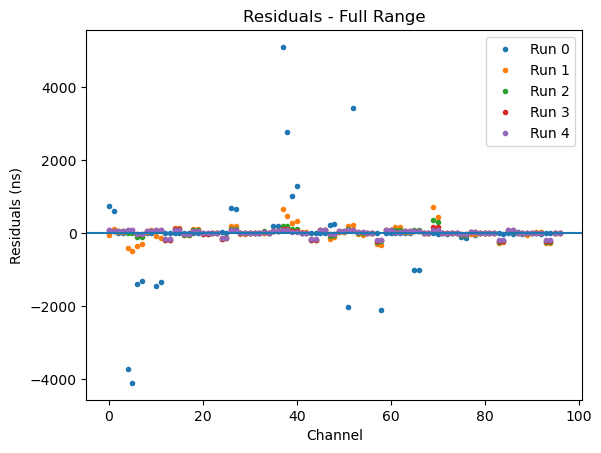

In [1151]:
#Plot the residuals
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Residuals (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(mean_res_arr[run, row, col, sipm])
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
#ax.set_ybound(-100, 100)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
#ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Residuals - Full Range")

Text(0.5, 1.0, 'Residuals - Narrow Range')

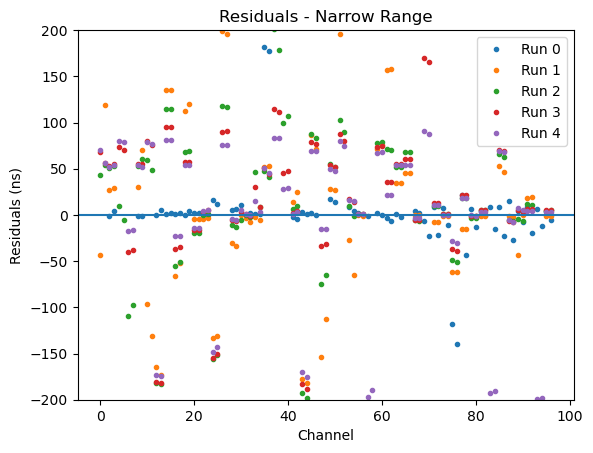

In [1152]:
#Plot the residuals
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Residuals (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(mean_res_arr[run, row, col, sipm])
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
ax.set_ybound(-200, 200)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
#ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Residuals - Narrow Range")

Text(0.5, 1.0, 'Number of residuals for each channel')

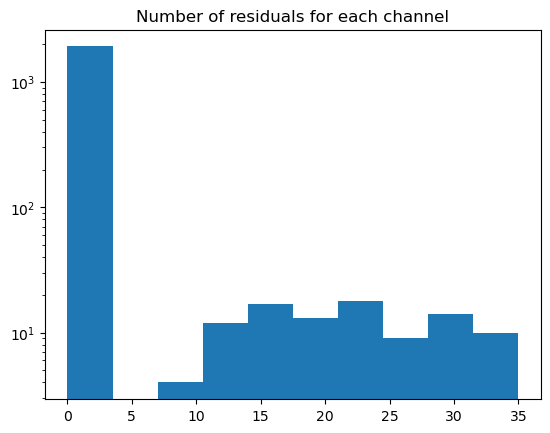

In [1153]:
#Draw tht distrigution of the number of residuals for a specic generation over all the channles
plt.hist(num_res_arr[0].flatten(), label= "Run " + str(run))
plt.yscale('log')
plt.title("Number of residuals for each channel")

Text(0.5, 1.0, 'Mean Residuals (all channels) - full range [ns]')

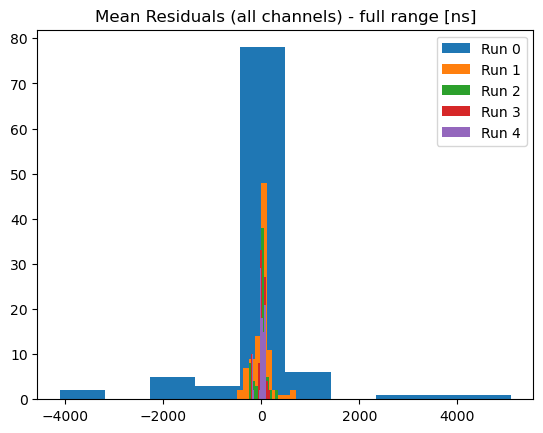

In [1154]:
#Draw the distibutions of the mean residuals for a specific iteration over all the channels
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    mean_arr = []
    for mean in mean_res_arr[run].flatten():
        scalar = mean.item()
        if not np.isnan(scalar):
            mean_arr.append(scalar)
    n, bin, patches = plt.hist(mean_arr, label= "Run " + str(run))
plt.legend()
plt.title("Mean Residuals (all channels) - full range [ns]")

Text(0.5, 1.0, 'Mean Residuals (all channels) - narrow range [ns]')

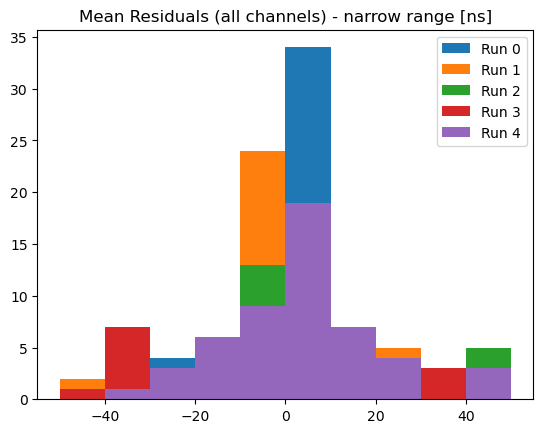

In [1155]:
#Draw the distibutions of the mean residuals for a specific iteration over all the channels
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    mean_arr = []
    for mean in mean_res_arr[run].flatten():
        scalar = mean.item()
        if not np.isnan(scalar):
            mean_arr.append(scalar)
    n, bin, patches = plt.hist(mean_arr, range= (-50, 50), label= "Run " + str(run))
plt.legend()
plt.title("Mean Residuals (all channels) - narrow range [ns]")

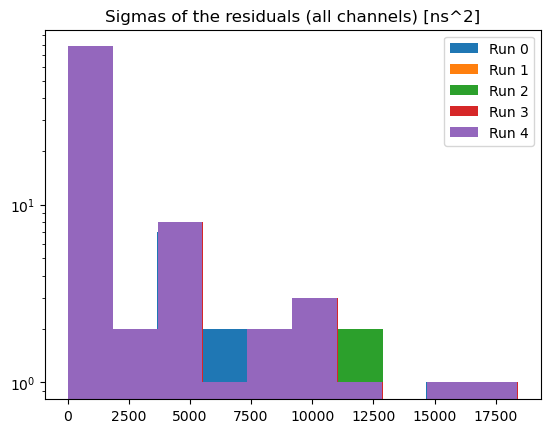

In [1156]:
#Draw the distibutions of the sigma of the residuals
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    sigma_arr = []
    for sigma in sigma_res_arr[run].flatten():
        scalar = sigma.item()
        if not np.isnan(scalar):
            sigma_arr.append(scalar)
    n, bin, patches = plt.hist(sigma_arr, label= "Run " + str(run))
plt.legend()
plt.title("Sigmas of the residuals (all channels) [ns^2]")
plt.yscale('log')

Text(0.5, 1.0, 'Residuals for Channel 15, 11, 1 ns')

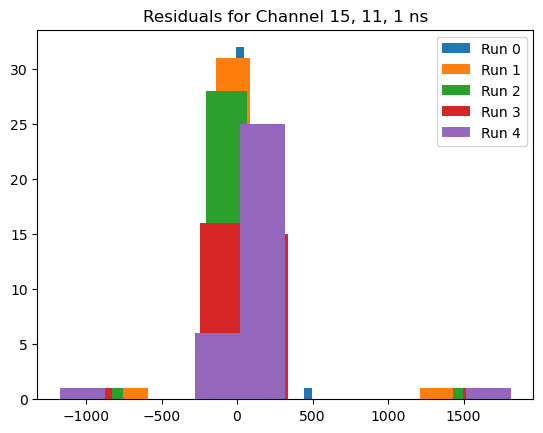

In [1172]:
#Draw the distribution of the residuals for a specific chennel
ch_num = 52 #Refers to the number of channels that have events
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    residuals = res_arr_list[run]
    plt.hist(residuals[residuals.fields[ch_num]], label= "Run " + str(run))
plt.legend()
plt.title("Residuals for Channel " + residuals.fields[ch_num] + " ns")

In [1158]:
channels = []
for row in range(N_ROWS):
    for col in range(N_COLUMNS):
        for sipm in range(N_SIPMS):
            if num_res_arr[0, row, col, sipm] >= RES_NUM_CUT:
                channels.append((row, col, sipm))
channels

[(3, 21, 0),
 (3, 21, 1),
 (4, 22, 0),
 (4, 22, 1),
 (4, 23, 0),
 (4, 23, 1),
 (5, 22, 0),
 (5, 22, 1),
 (5, 23, 0),
 (5, 23, 1),
 (5, 24, 0),
 (5, 24, 1),
 (6, 22, 0),
 (6, 22, 1),
 (6, 23, 0),
 (6, 23, 1),
 (6, 24, 0),
 (6, 24, 1),
 (6, 25, 0),
 (6, 25, 1),
 (7, 15, 0),
 (7, 15, 1),
 (7, 16, 0),
 (7, 16, 1),
 (7, 17, 0),
 (7, 17, 1),
 (7, 18, 0),
 (7, 18, 1),
 (8, 10, 0),
 (8, 10, 1),
 (8, 11, 1),
 (8, 12, 0),
 (8, 12, 1),
 (9, 9, 0),
 (9, 9, 1),
 (14, 12, 0),
 (14, 12, 1),
 (14, 13, 0),
 (14, 13, 1),
 (14, 15, 0),
 (14, 15, 1),
 (15, 7, 0),
 (15, 7, 1),
 (15, 8, 0),
 (15, 8, 1),
 (15, 9, 0),
 (15, 9, 1),
 (15, 10, 0),
 (15, 10, 1),
 (15, 11, 0),
 (15, 11, 1),
 (15, 12, 0),
 (15, 12, 1),
 (15, 13, 0),
 (15, 13, 1),
 (16, 7, 0),
 (16, 7, 1),
 (16, 8, 0),
 (16, 8, 1),
 (16, 9, 0),
 (16, 9, 1),
 (16, 10, 0),
 (16, 10, 1),
 (16, 11, 0),
 (16, 11, 1),
 (16, 12, 0),
 (16, 12, 1),
 (16, 13, 0),
 (16, 13, 1),
 (22, 9, 0),
 (22, 9, 1),
 (22, 11, 0),
 (22, 11, 1),
 (22, 12, 0),
 (22, 12, 1),
 

Text(0.5, 1.0, 'Residuals for Channel 9, 9, 0 ns')

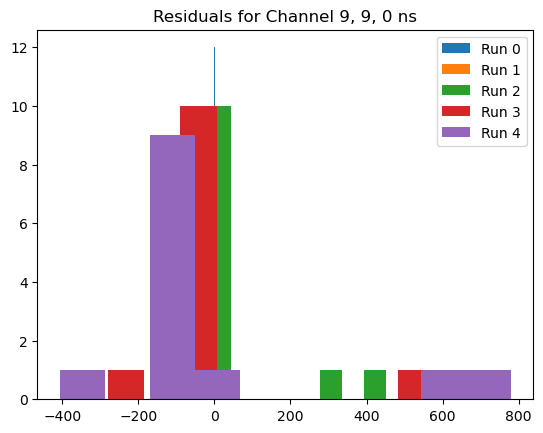

In [1173]:
#Draw the distribution of the residuals for a specific chennel
channel = "9, 9, 0"
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    residuals = res_arr_list[run]
    plt.hist(residuals[channel], label= "Run " + str(run))
plt.legend()
plt.title("Residuals for Channel " + channel + " ns")

Text(0.5, 1.0, 'Calibration corrections ns')

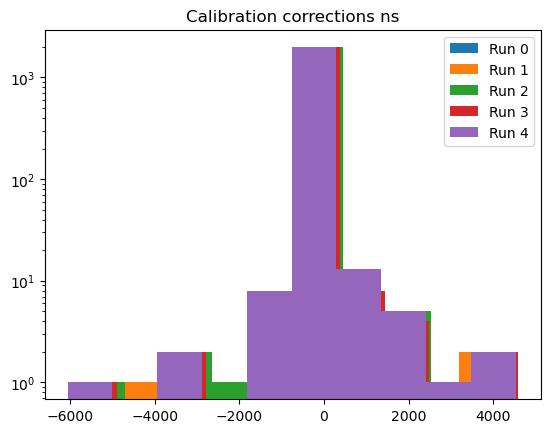

In [1160]:
#Plot calibration values distribution
for run in range(0, n_runs, GRAPH_RUNS_STEP):
    calibration = cal_corr_arr[run]
    values = []
    for value in calibration.flatten():
        scalar = value.item()
        values.append(scalar)
    plt.hist(values, label= "Run " + str(run))
plt.yscale('log')
plt.legend()
plt.title("Calibration corrections ns")

Text(0.5, 1.0, 'Calibrations')

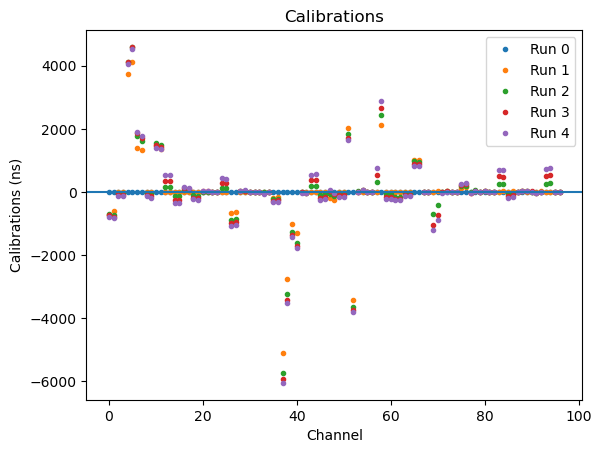

In [1161]:
#Plot the coorections
fig, ax = plt.subplots()
ax.set_xlabel("Channel")
ax.set_ylabel("Calibrations (ns)")

for run in range(0, n_runs, GRAPH_RUNS_STEP):
    y_values = []
    for row in range(N_ROWS):
        for col in range(N_COLUMNS):
            for sipm in range(N_SIPMS):
                if num_res_arr[run, row, col, sipm] >= RES_NUM_CUT:
                    y_values.append(cal_corr_arr[run][row, col, sipm].item())
    ax.plot(y_values, marker = '.', linestyle= 'none', label= "Run " + str(run))
plt.axhline(0)
ax.legend()
#ax.set_ybound(-100, 100)
#ax.set_ybound(-50, 50)
#ax.set_ybound(-5, 5)
#ax.set_ybound(-2, 2)
#ax.set_ybound(-1, 1)
plt.title("Calibrations")

In [1162]:
cal_corr_arr[4][15, 11, 0]

array(-154.1786569) * ns

Text(0.5, 1.0, 'Distributions of sin theta')

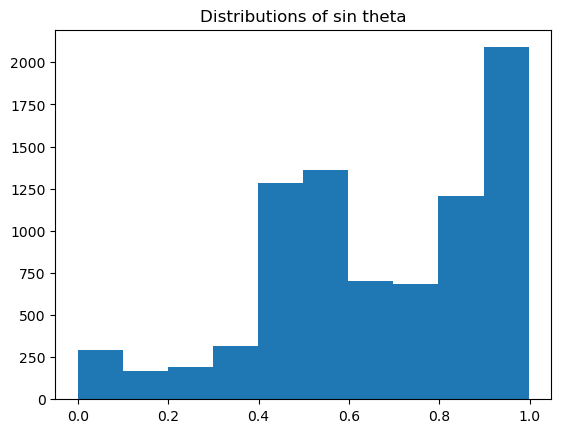

In [1167]:
#cos theta plot
sin_theta_arr = []
for event in tree:
    if event.slope:
        #Select events that have a not "None" slope
        sin_theta = abs(event.slope) / np.sqrt(1 + event.slope ** 2)
        sin_theta_arr.append(sin_theta)
        
plt.hist(sin_theta_arr)
plt.title("Distributions of sin theta")  

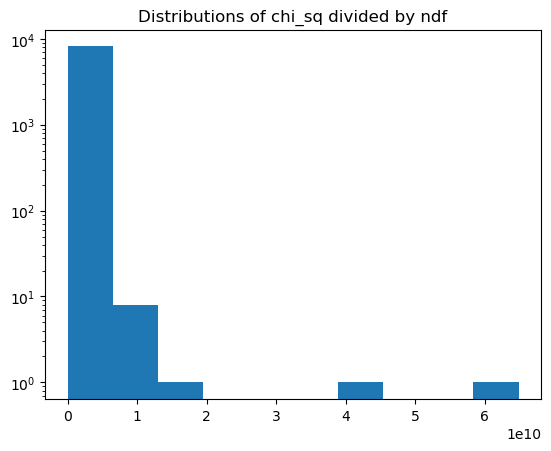

In [1164]:
#chi/ndf plot
chi_on_ndf_arr = []
for event in tree:
    if event.chi_sq:
        chi_on_ndf_arr.append(event.chi_sq / event.ndf)
        
plt.hist(chi_on_ndf_arr)
plt.title("Distributions of chi_sq divided by ndf")
plt.yscale('log')

In [1165]:
np.count_nonzero(tree.vertical)

np.int64(39174)

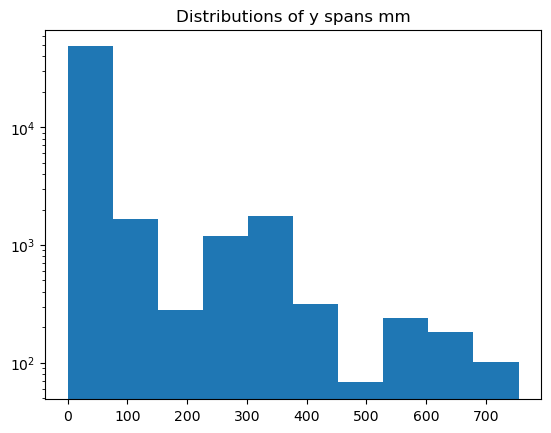

In [1166]:
#Y span graph
y_spans = []
for event in tree:
    y_spans.append(event.y_span())
    
plt.hist(y_spans)
plt.title("Distributions of y spans mm")
plt.yscale('log')